# Style Transfer

An example below is inspired [by this blog post](https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216), and a lot of code is borrowed from there. Another good example of Style Transfer using CNTK framework is [here](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_205_Artistic_Style_Transfer.ipynb). Here is an original paper on [Artistic Style Transfer](https://arxiv.org/abs/1508.06576).

Main ideas behind style transfer are the following:

* Starting from white noise, we try to optimize the current image $x$ to minimize some loss function
* Loss function consists of three components $\mathcal{L(x)} = \alpha\mathcal{L}_c(x,i) + \beta\mathcal{L}_s(x,s)+\gamma\mathcal{L}_t(x)$
   - $\mathcal{L}_c$ - content loss - shows how close the current image $x$ is to original image $i$
   - $\mathcal{L}_s$ - style loss - shows how close the current image $x$ is to style image $s$
   - $\mathcal{L}_t$ - total variation loss (we will not consider it in our example) - makes sure that the resulting image is smooth, i.e. it shows the mean squared error of neighbouring pixels of the image $x$
   
Those loss functions have to be designed in a clever way, so that for example style loss corresponds to styles of the images being similar, and not the actual content. For that, we will compare some deeper feature layers of a CNN which looks at the image.

Let's start by loading a couple of images:

In [1]:
!curl https://cdn.pixabay.com/photo/2016/05/18/00/27/franz-marc-1399594_960_720.jpg > images/style.jpg
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_tabby_and_white_kitten_n01.jpg/1280px-Golden_tabby_and_white_kitten_n01.jpg > images/image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  210k  100  210k    0     0   208k      0  0:00:01  0:00:01 --:--:--  208k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0   184k      0 --:--:-- --:--:-- --:--:--  185k


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

Let's load those images and resize them to $512\times512$. Also, we will generate resulting image `img_result` as a random array.

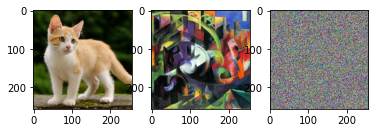

In [5]:
img_size = 256

def load_image(fn):
  x = cv2.imread(fn)
  return cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img_style = load_image('images/style.jpg')
img_content = load_image('images/image.jpg')
img_content = img_content[:,200:200+857,:]
img_content = cv2.resize(img_content,(img_size,img_size))
img_style = img_style[:,200:200+671,:]
img_style = cv2.resize(img_style,(img_size,img_size))

img_result = np.random.randint(256,size=(img_size,img_size,3)).astype(np.float64)

fig,ax = plt.subplots(1,3)
ax[0].imshow(img_content)
ax[1].imshow(img_style)
ax[2].imshow(img_result.astype(np.int))
plt.show()

In [2]:
import tensorflow as tf
from tf.keras import backend as K
from tf.keras.applications.vgg16 import preprocess_input
from tf.keras.applications import VGG16
from tf.keras.preprocessing.image import load_img, img_to_array
tf_session = K.get_session()

In [ ]:
img_content_var = K.variable(preprocess_input(np.expand_dims(img_content, axis=0)), dtype='float32')
img_style_var = K.variable(preprocess_input(np.expand_dims(img_style, axis=0)), dtype='float32')
img_result_1 = preprocess_input(np.expand_dims(img_result, axis=0))
img_result_holder = K.placeholder(shape=(1, img_size, img_size, 3))

To calculate style loss and content loss, we need to work in the feature space extracted by a CNN. We can use different CNN architectures, but for simplicity in our case we will chose VGG-16, pre-trained on *ImageNet*.

In [ ]:
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_content_var)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_style_var)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=img_result_holder)

Let's have a look at the model architecture:

In [7]:
gModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Content Loss

**Content loss** will show how close our current image $x$ is to the original image. It looks at the intermediate feature layers in CNN, and computes square error. Content loss on layer $l$ will be defined as
$$
\mathcal{L}_c = {1\over2}\sum_{i,j} (F_{ij}^{(l)}-P_{ij}^{(l)})^2
$$
where $F^{(l)}$ and $P^{(l)}$ -- features at layer $l$.

In [ ]:
def get_feature_reps(x, layer_names, model):
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

Let's see how features at different layers affect the image. To do that, we will try to minimize content loss for just one layer. We will use `fmin_l_bfgs_b` function from SciPy, which take the function to be minimized and its gradient (in our case, `help_loss` function returns both the loss function and the gradient).

**Important**: in our case, all computations are performed using GPU-aware *TensorFlow* framework. `helper_loss` function returns computational graph, which can be used to compute the loss for a given image, and it uses `K.gradients` to automatically compute gradients.

In [ ]:
layer='block4_conv2'
P = get_feature_reps(x=img_content_var, layer_names=[layer], model=cModel)[0]
x = img_result.flatten()
def helper_loss(img):
    R = get_feature_reps(img,[layer],gModel)[0]
    return get_content_loss(R,P)
  
def help_loss(x):
    if x.shape != (1, img_size, img_size, 3):
        x = x.reshape((1,img_size, img_size, 3))
    keras_fcn = K.function([gModel.input], [helper_loss(gModel.input)])
    keras_grad = K.function([gModel.input], K.gradients(helper_loss(gModel.input),[gModel.input]))
    return keras_fcn([x])[0].astype('float64'),keras_grad([x])[0].flatten().astype('float64')

x, _, _ = fmin_l_bfgs_b(help_loss, x, maxiter=30, disp=True)

In [ ]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (img_size, img_size, 3):
        x = x.reshape((img_size, img_size, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x


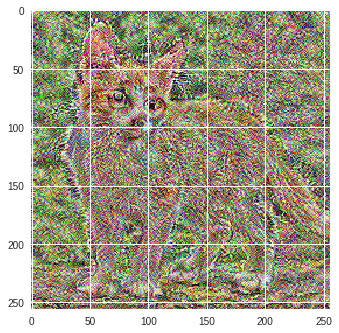

In [22]:
plt.imshow(postprocess_array(x.copy()))
plt.show()

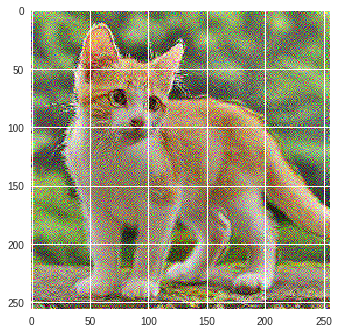

In [26]:
layer='block3_conv2'
P = get_feature_reps(x=img_content_var, layer_names=[layer], model=cModel)[0]
x = img_result.flatten()
x, _, _ = fmin_l_bfgs_b(help_loss, x, maxiter=30, disp=True)
plt.imshow(postprocess_array(x.copy()))
plt.show()

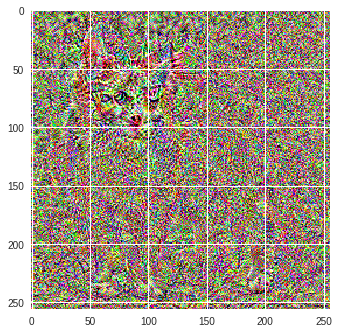

In [28]:
layer='block5_conv1'
P = get_feature_reps(x=img_content_var, layer_names=[layer], model=cModel)[0]
x = img_result.flatten()
x, _, _ = fmin_l_bfgs_b(help_loss, x, maxiter=30, disp=True)
plt.imshow(postprocess_array(x.copy()))
plt.show()

## Style Loss


Style loss is the main idea behind Style Transfer. We compare not the actual features, but their Gram matrices, which are defined as $$G=A\times A^T$$

Gram matrix is similar to correlation matrix, and it shows how some filters depend on the others. Style Loss is computed as a sum of losses from different layers, which are often considered with weighted coefficients.

Total loss function for style transfer is a sum of *content loss* and *style loss*.

In [ ]:
def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss+= w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss
  
def get_total_loss(gImPlaceholder, alpha=1.0, beta=30.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[content_layer_name], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=style_layer_names, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss
 

## Putting it all together

Here `calualate_loss` function will calculate total loss:

In [ ]:
def calculate_loss(gImArr):
  """
  Calculate total loss using K.function
  """
  if gImArr.shape != (1, img_size, img_size, 3):
        gImArr = gImArr.reshape((1,img_size, img_size, 3))
  loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
  grad_fcn = K.function([gModel.input], 
                        K.gradients(get_total_loss(gModel.input), [gModel.input]))
  return loss_fcn([gImArr])[0].astype('float64'),grad_fcn([gImArr])[0].flatten().astype('float64')

content_layer_name = 'block4_conv2'
style_layer_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']

P = get_feature_reps(x=img_content_var, layer_names=[content_layer_name], model=cModel)[0]
As = get_feature_reps(x=img_style_var, layer_names=style_layer_names, model=sModel)
ws = np.ones(len(style_layer_names))/float(len(style_layer_names))

img_result = np.random.randint(256,size=(img_size,img_size,3)).astype(np.float64)
img_result_1 = preprocess_input(np.expand_dims(img_result, axis=0))

iterations = 10
x_opt = img_result_1.flatten()

The code below performs the actual optimization of loss. Keep in mind that even with GPU the optimization takes significant amount of time. You can run the cell below several times to improve the result.

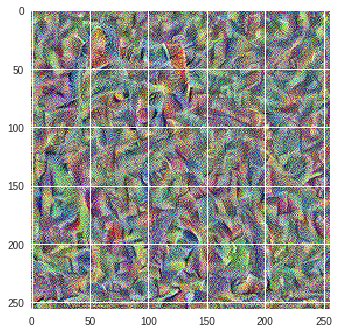

In [16]:
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_opt, maxiter=iterations, disp=True)
plt.imshow(postprocess_array(xopt.copy()))
plt.show()

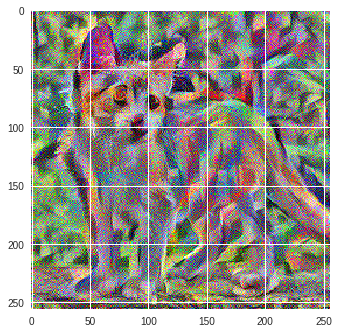

In [14]:
iterations = 20
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, xopt, fprime=get_grad,
                            maxiter=iterations, disp=True)
plt.imshow(postprocess_array(xopt.copy()))
plt.show()

## Add variation loss

**Variation loss** allows us to make the image less noisy, by minimizing the amount of difference between neighbouring pixels.

In [ ]:
def total_variation_loss(x):
    a = K.square(x[:,:img_size-1,:img_size-1,:] - x[:, 1:, :img_size-1,:])
    b = K.square(x[:,:img_size-1,:img_size-1,:] - x[:, :img_size-1, 1:,:])
    return K.sum(K.pow(a + b, 1.25))
  
def get_total_loss(gImPlaceholder, alpha=1.0, beta=30.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[content_layer_name], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=style_layer_names, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    variationLoss = total_variation_loss(gImPlaceholder)
    totalLoss = alpha*contentLoss + beta*styleLoss + variationLoss
    return totalLoss

img_result = np.random.randint(256,size=(img_size,img_size,3)).astype(np.float64)
img_result_1 = preprocess_input(np.expand_dims(img_result, axis=0))
iterations = 10
x_opt = img_result_1.flatten()


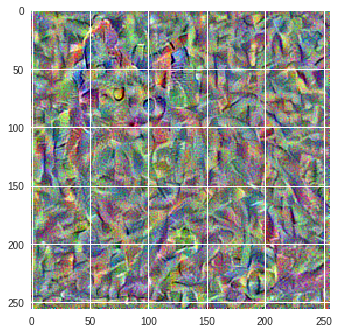

In [44]:
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_opt, maxiter=iterations, disp=True)
plt.imshow(postprocess_array(xopt.copy()))
plt.show()